# Combine data from different sources: 

In [227]:
from bs_fdbck.constants import path_measurement_data

In [228]:
import pandas as pd
import numpy as np
import xarray as xr

### Input data:


In [229]:
path_sizedist_ATTO = path_measurement_data /'ATTO'#'sizedistrib' 

In [230]:
list(path_sizedist_ATTO.glob('*'))

[PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/ATTO/processed'),
 PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/ATTO/QACSM_time_series_C4_60m_2014_2016STP_v3.xlsx'),
 PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/ATTO/sizedistrib'),
 PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/ATTO/daily_median_QACSM_time_series_C4_60m_2014_2016STP_v3.csv'),
 PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/ATTO/meteodataComplete.dat'),
 PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/ATTO/ds_atto_2014_2019_4Sara.nc')]

In [231]:
path_acsm = path_measurement_data / 'ATTO'/ 'QACSM_time_series_C4_60m_2014_2016STP_v3.xlsx'

In [234]:
fn_theo = path_measurement_data / 'ATTO'/ 'ds_atto_2014_2019_4Sara.nc'

In [235]:
fn_meteo = path_measurement_data / 'ATTO'/ 'meteodataComplete.dat'

### Output data

In [232]:
postproc_data = path_measurement_data /'ATTO'/'processed'
postproc_data.mkdir( exist_ok=True)

In [233]:
path_acsm_daily_median = postproc_data /'daily_median_QACSM_time_series_C4_60m_2014_2016STP_v3.csv'

path_comb_data =postproc_data /'ATTO_data_comb_daily.nc'
path_comb_data_full_time =postproc_data /'ATTO_data_comb_hourly.nc'

### Read in acsm data

In [236]:
df_ATTO = pd.read_excel(path_acsm, sheet_name=0, index_col=0)#'QACSM 60m v3')

In [237]:
df_ATTO.index = df_ATTO.index.rename('time')

## ATTO is at UTC - 4: convert to local time 

In [238]:
import datetime

In [239]:
df_ATTO.index

Index(['1/1/2014 0:00', '1/1/2014 0:30', '1/1/2014 1:00', '1/1/2014 1:30',
       '1/1/2014 2:00', '1/1/2014 2:30', '1/1/2014 3:00', '1/1/2014 3:30',
       '1/1/2014 4:00', '1/1/2014 4:30',
       ...
       '1/3/2017 8:30', '1/3/2017 9:00', '1/3/2017 9:30', '1/3/2017 10:00',
       '1/3/2017 10:30', '1/3/2017 11:00', '1/3/2017 11:30', '1/3/2017 12:00',
       '1/3/2017 12:30', '1/3/2017 13:00'],
      dtype='object', name='time', length=52731)

In [240]:
time_ind = pd.to_datetime(df_ATTO.index)# -datetime.timedelta(hours=4)

In [241]:
time_ind_local_time = time_ind - datetime.timedelta(hours=4)
time_ind_local_time

DatetimeIndex(['2013-12-31 20:00:00', '2013-12-31 20:30:00',
               '2013-12-31 21:00:00', '2013-12-31 21:30:00',
               '2013-12-31 22:00:00', '2013-12-31 22:30:00',
               '2013-12-31 23:00:00', '2013-12-31 23:30:00',
               '2014-01-01 00:00:00', '2014-01-01 00:30:00',
               ...
               '2017-01-03 04:30:00', '2017-01-03 05:00:00',
               '2017-01-03 05:30:00', '2017-01-03 06:00:00',
               '2017-01-03 06:30:00', '2017-01-03 07:00:00',
               '2017-01-03 07:30:00', '2017-01-03 08:00:00',
               '2017-01-03 08:30:00', '2017-01-03 09:00:00'],
              dtype='datetime64[ns]', name='time', length=52731, freq=None)

In [242]:
df_ATTO.index = time_ind_local_time

In [243]:
df_ATTO_daily_med = df_ATTO.resample('1D').median()

<AxesSubplot:xlabel='time'>

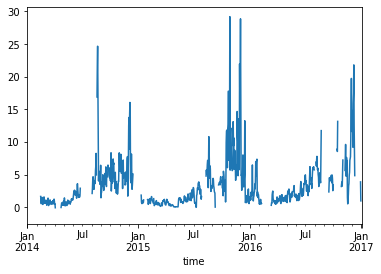

In [244]:
df_ATTO_daily_med['org (ug m-3)'].plot()

In [245]:
df_ATTO_daily_med['org (ug m-3)']

time
2013-12-31         NaN
2014-01-01         NaN
2014-01-02         NaN
2014-01-03         NaN
2014-01-04         NaN
                ...   
2016-12-30    3.880180
2016-12-31    0.968279
2017-01-01         NaN
2017-01-02         NaN
2017-01-03         NaN
Freq: D, Name: org (ug m-3), Length: 1100, dtype: float64

In [246]:
df_ATTO_daily_med = df_ATTO_daily_med.rename({'org (ug m-3)':'Org'}, axis=1)

In [247]:
df_ATTO_daily_med.to_csv(path_acsm_daily_median)

## Data from Theodore

In [248]:
ds = xr.open_dataset(fn_theo, engine='netcdf4')
ds['timeUTC-3'] = ds['time'].copy()

In [249]:
import matplotlib.pyplot as plt

### Add meteo data:

In [250]:
df_met = pd.read_csv(fn_meteo, sep='\t', index_col=0)

In [251]:
df_met = df_met.replace(9999,np.nan).rename({' temperature':'temperature'}, axis=1)

<AxesSubplot:xlabel='TimeUTC'>

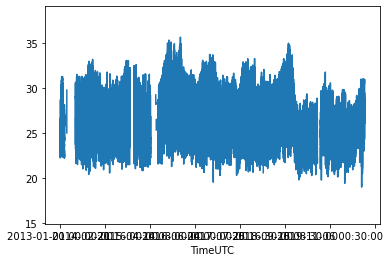

In [252]:
df_met['temperature'].plot()

In [253]:
vars_to_add_meteo = ['pressure', 'temperature', 'humidity', 'wind_dir', 'precip',
       'Solar_inc_Wm2', 'Solar_out_Wm2', 'wind_speed', 'wind_speed_v']


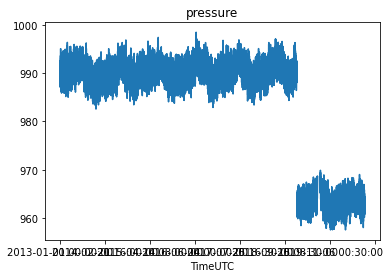

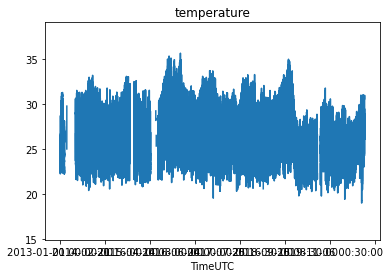

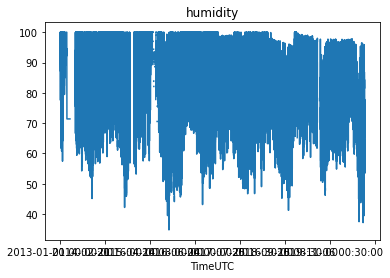

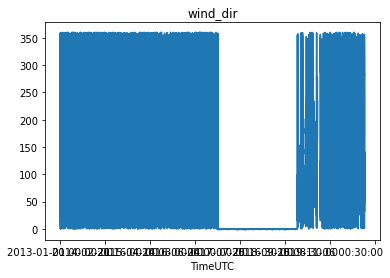

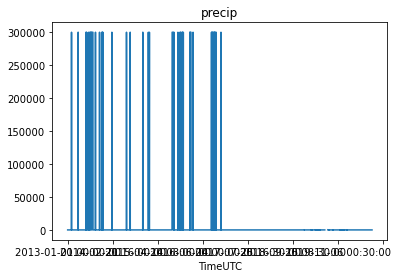

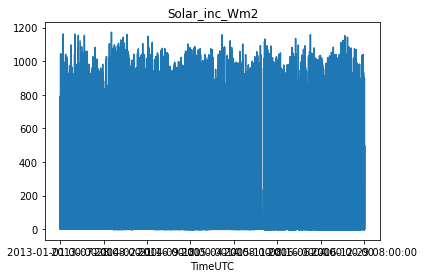

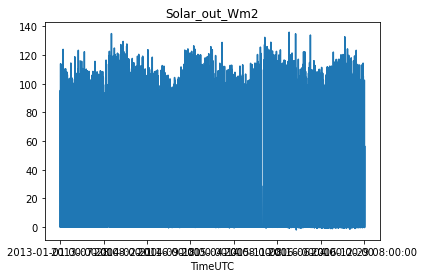

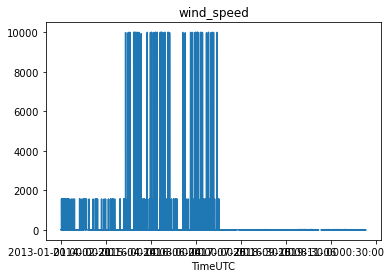

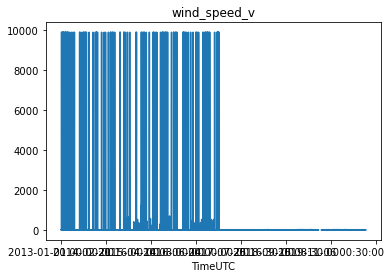

In [254]:

for v in vars_to_add_meteo:
    df_met[v].plot()
    plt.title(v)
    plt.show()

In [255]:
df_met['wind_speed'][df_met['wind_speed']>100] = np.nan
df_met['wind_speed_v'][df_met['wind_speed_v']>100] = np.nan

In [256]:
df_met['precip'][df_met['precip']>4000] = np.nan
#.plot()

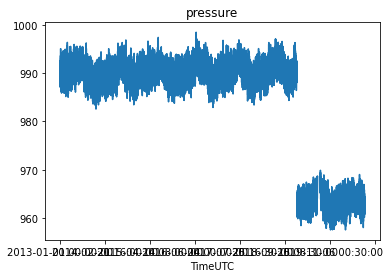

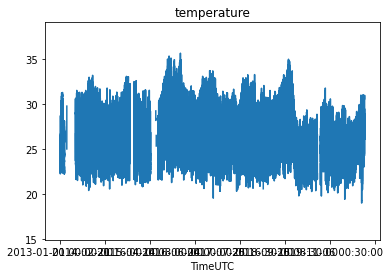

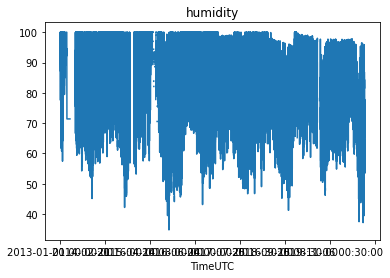

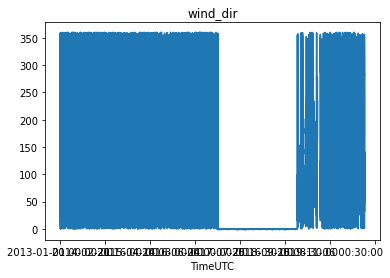

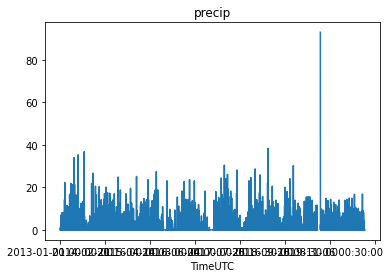

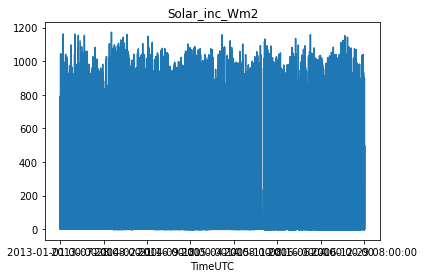

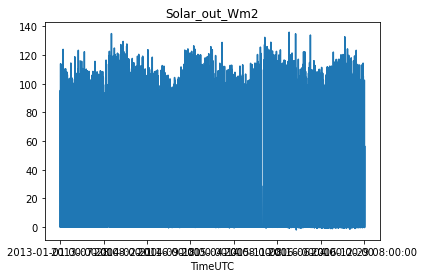

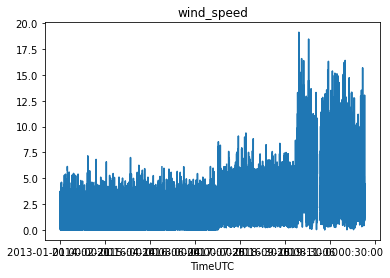

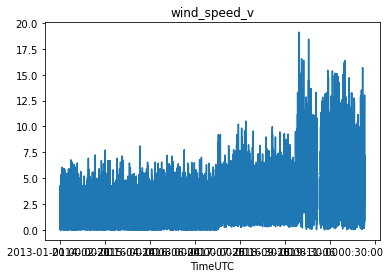

In [257]:

for v in vars_to_add_meteo:
    df_met[v].plot()
    plt.title(v)
    plt.show()

#### Go from UTC time to local time

In [258]:
df_met = df_met.reset_index()
df_met['TimeLocal'] = pd.to_datetime(df_met['TimeUTC']) - datetime.timedelta(hours=4)

df_met = df_met.set_index('TimeLocal')


In [259]:
df_met['hour'] = df_met.index.hour

In [260]:
df_met.columns

Index(['TimeUTC', 'pressure', 'temperature', 'humidity', 'wind_dir', 'precip',
       'Solar_inc_Wm2', 'Solar_out_Wm2', 'wind_speed', 'wind_speed_v', 'hour'],
      dtype='object')

In [261]:
df_met_daily_med = df_met.resample('D').median()

In [262]:
df_met_daily_cycle = df_met.groupby(df_met['hour']).mean()

## Seems like Theos data is UTC-3, so we shift all to -4

In [263]:
ds['timeUTC'] = pd.to_datetime(ds['timeUTC-3']) + datetime.timedelta(hours=3)
ds['timeUTC-4'] = pd.to_datetime(ds['timeUTC']) - datetime.timedelta(hours=4)

ds['time'] = ds['timeUTC-4'].values

In [264]:
ds

<xarray.Dataset>
Dimensions:                (D: 104, time: 25448, time_traj: 121, timeUTC: 25448, timeUTC-4: 25448)
Coordinates:
  * D                      (D) float64 10.2 10.6 10.9 11.3 ... 385.4 399.5 414.2
  * time                   (time) datetime64[ns] 2014-03-10T15:00:00 ... 2019...
  * time_traj              (time_traj) int64 0 1 2 3 4 5 ... 116 117 118 119 120
  * timeUTC                (timeUTC) datetime64[ns] 2014-03-10T19:00:00 ... 2...
  * timeUTC-4              (timeUTC-4) datetime64[ns] 2014-03-10T15:00:00 ......
Data variables: (12/20)
    pnsd                   (time, D) float64 ...
    Pressure               (time, time_traj) float64 ...
    Potential_Temperature  (time, time_traj) float64 ...
    Temperature            (time, time_traj) float64 ...
    Rainfall               (time, time_traj) float64 ...
    Mixing_Depth           (time, time_traj) float64 ...
    ...                     ...
    condensation_sink      (time) float64 ...
    pnsd_nolog             (time, D) float64 ...
    N50                    (time) float64 ...
    N100                   (time) float64 ...
    N200                   (time) float64 ...
    timeUTC-3              (time) datetime64[ns] 2014-03-10T16:00:00 ... 2019...

In [265]:
ds['hour'] = ds['time.hour']

<AxesSubplot:xlabel='hour'>

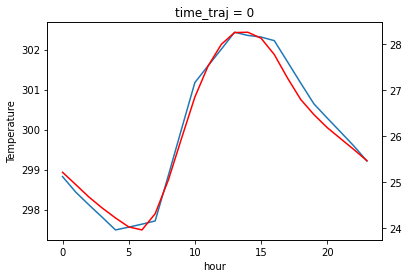

In [267]:
f,ax = plt.subplots()
ds['Temperature'].isel(time_traj=0).groupby(ds['hour']).mean().plot()

df_met_daily_cycle['temperature'].plot(ax = ax.twinx(), c='r')

### Rename reanalysis variables and add meteo variables to final dataset

In [269]:
ds = ds.rename(dict(
    Pressure='Pressure_reanalysis',
    Temperature='Temperature_reanalysis',
    Potential_Temperature='Potential_Temperature_reanalysis',
    Specific_Humidity = 'Specific_Humidity_reanalysis',
    
))

In [270]:
from_dt = ds['time'].isel(time=0).values
to_dt = ds['time'].isel(time=-1).values


for v in vars_to_add_meteo:
    xa = xr.DataArray(df_met[v]).rename(dict(TimeLocal='time'))
    ds[v] = xa.sel(time=slice(from_dt, to_dt))

In [271]:
ds_stat = ds.sel(time_traj = 0)

In [272]:
ds_stat_day = ds_stat.resample({'time':'D'}).median()

In [273]:
ds_stat_day = ds_stat_day.assign({'Org':df_ATTO_daily_med.to_xarray()['Org']})

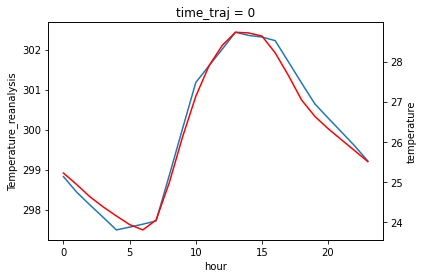

In [278]:
f,ax = plt.subplots()
ds['Temperature_reanalysis'].isel(time_traj=0).groupby(ds['hour']).mean().plot()
ds['temperature'].groupby(ds['hour']).mean().plot(ax = ax.twinx(), c='r')


In [280]:
ds_stat_day.to_netcdf(path_comb_data)

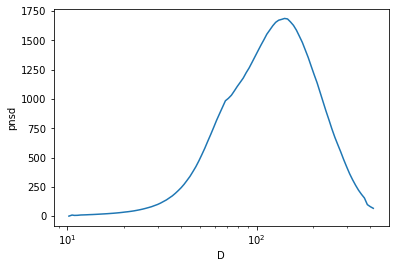

In [281]:
ds['pnsd'].mean('time').plot(xscale='log')

In [282]:
ds_nx = ds_stat_day

<AxesSubplot:xlabel='time'>

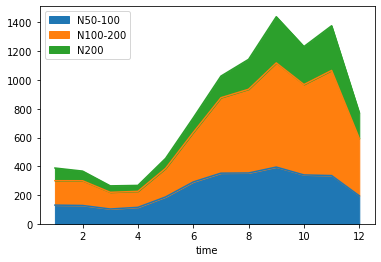

In [283]:
ds_nx['N50-100'] = ds_nx['N50']-ds_nx['N100']
ds_nx['N100-200'] = ds_nx['N100']-ds_nx['N200']
_df = ds_nx[['N50-100','N100-200','N200']].to_dataframe().drop('time_traj', axis=1)

_df.groupby(_df.index.month).median().plot(kind='area', stacked='true',)#, alpha=.2)



In [284]:
ds['N50'].mean('time')

<xarray.DataArray 'N50' ()>
array(925.84488543)

In [285]:
ds['N100'].mean('time')

<xarray.DataArray 'N100' ()>
array(637.09319922)

In [286]:
ds['N200'].mean('time')

<xarray.DataArray 'N200' ()>
array(176.91365316)

In [287]:
ds = ds.assign({'OA':df_ATTO['org (ug m-3)'].resample('h').mean()})

In [288]:
ds.to_netcdf(path_comb_data_full_time)

In [289]:
ds_stat_day.plot.scatter(x='Temperature', y='Org', alpha=.5)

ValueError: x must be one of (timeUTC-4, wind_dir, time_traj, z, Potential_Temperature_reanalysis, condensation_sink, hour, x, pnsd_nolog, wind_speed, N200, humidity, Pressure_reanalysis, Mixing_Depth, Specific_Humidity_reanalysis, wind_speed_v, precip, N100-200, y, Terrain_Altitude, Solar_Radiation, time, Org, N50, Rainfall, Temperature_reanalysis, N100, temperature, Mixing_Ratio, pressure, D, pnsd, Relative_Humidity, Solar_out_Wm2, timeUTC, Solar_inc_Wm2, N50-100)

In [ ]:
ds_stat_day.plot.scatter(x='Org', y='N100', alpha=.5)

In [ ]:
ds_stat_day.plot.scatter(x='Org', y='N200', alpha=.5)

In [ ]:
ds_stat_day.plot.scatter(x='Org', y='N50', alpha=.5)

In [ ]:
ds_stat_day

In [ ]:
ds['z'].plot(robust=True)

In [ ]:
ds['z'].isel(time_traj=0).plot()

In [ ]:
ds['z'].isel(time_traj=1).plot()

In [ ]:
ds['z'].isel(time_traj=-1).plot()